In [1]:
import torch
import torch.nn as nn
import torchvision
from gan import *
from torchinfo import summary
from torchvision import transforms
from torchvision.utils import save_image
import os

c:\Users\victolee\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\victolee\anaconda3\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
c:\Users\victolee\anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
c:\Users\victolee\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
sample_dir = 'samples'

# Create a directory if not exists
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)


In [3]:
BATCHSIZE=100
LATENTSIZE=64

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])
mnist = torchvision.datasets.MNIST(root='../data/', train=True, transform=transform, download=True)
dataloader = torch.utils.data.DataLoader(mnist, batch_size=BATCHSIZE, shuffle=True, drop_last=True)

c:\Users\victolee\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
G = Generator([LATENTSIZE, 256, 256, 28*28]).cuda()
D = Discriminator([28*28, 256, 256, 1]).cuda()

In [5]:
G

Generator(
  (layer): Sequential(
    (0): Sequential(
      (0): Linear(in_features=64, out_features=256, bias=True)
      (1): ReLU6()
    )
    (1): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ReLU6()
    )
  )
  (layer1): Linear(in_features=256, out_features=784, bias=True)
  (tanh): Tanh()
)

In [6]:
D

Discriminator(
  (layer): Sequential(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
      (2): Dropout(p=0.1, inplace=False)
    )
    (1): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
      (2): Dropout(p=0.1, inplace=False)
    )
  )
  (layer1): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [7]:
criterion = nn.BCELoss()
G_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)
D_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)

In [8]:
def reset_grad():
    D_optimizer.zero_grad()
    G_optimizer.zero_grad()
    

def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)


In [9]:
EPOCHS = 200
for epoch in range(EPOCHS):
    for i, (image, label) in enumerate(dataloader):
        
        image = image.reshape(BATCHSIZE, 28*28).cuda()

        real = torch.ones(BATCHSIZE, 1).cuda()
        fake = torch.zeros(BATCHSIZE, 1).cuda()

        outputs = D(image)
        real_score = outputs
        d_loss_real = criterion(outputs, real)

        z = torch.randn(BATCHSIZE, LATENTSIZE).cuda()
        fake_img = G(z)
        outputs = D(fake_img)
        fake_score = outputs
        d_loss_fake = criterion(outputs, fake)

        d_loss = d_loss_real + d_loss_fake

        reset_grad()
        d_loss.backward()
        D_optimizer.step()

        z = torch.randn(BATCHSIZE, LATENTSIZE).cuda()
        fake_img = G(z)
        outputs = D(fake_img)
        
        g_loss = criterion(outputs, real)

        reset_grad()
        g_loss.backward()
        G_optimizer.step()

        if (i+1) % 200 == 0:
            print(f'Epoch[{epoch+1}/{EPOCHS}], Step[{i+1}/{len(dataloader)}] d_loss: {d_loss.item():.4f} g_loss: {g_loss.item():.4f} \
                D(x): {real_score.mean().item():2f} D(G(z)): {fake_score.mean().item():2f}')

    if (epoch+1) == 1:
        images = image.reshape(image.size(0), 1, 28, 28)
        save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'))
    
    # Save sampled images
    fake_images = fake_img.reshape(fake_img.size(0), 1, 28, 28)
    save_image(denorm(fake_images), os.path.join(sample_dir, 'fake_images-{}.png'.format(epoch+1)))


Epoch[1/200], Step[200/600] d_loss: 0.0522 g_loss: 4.4499                 D(x): 0.995859 D(G(z)): 0.045844
Epoch[1/200], Step[400/600] d_loss: 0.0834 g_loss: 5.5958                 D(x): 0.968583 D(G(z)): 0.040498
Epoch[1/200], Step[600/600] d_loss: 0.1903 g_loss: 3.9628                 D(x): 0.917387 D(G(z)): 0.087762
Epoch[2/200], Step[200/600] d_loss: 0.2664 g_loss: 3.9076                 D(x): 0.892578 D(G(z)): 0.102895
Epoch[2/200], Step[400/600] d_loss: 0.2342 g_loss: 2.7972                 D(x): 0.972075 D(G(z)): 0.149763
Epoch[2/200], Step[600/600] d_loss: 0.4450 g_loss: 2.3894                 D(x): 0.901634 D(G(z)): 0.221192
Epoch[3/200], Step[200/600] d_loss: 0.7179 g_loss: 1.4921                 D(x): 0.782315 D(G(z)): 0.293462
Epoch[3/200], Step[400/600] d_loss: 0.7059 g_loss: 1.7740                 D(x): 0.840227 D(G(z)): 0.347224
Epoch[3/200], Step[600/600] d_loss: 0.2065 g_loss: 3.8257                 D(x): 0.914113 D(G(z)): 0.062800
Epoch[4/200], Step[200/600] d_loss: 0

In [10]:
img = fake_img.detach().cpu().reshape((BATCHSIZE, 28, 28))

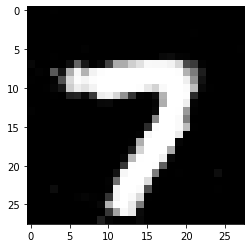

In [11]:
import matplotlib.pyplot as plt
plt.imshow(img[0], cmap='gray')

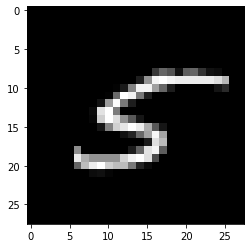

In [12]:
plt.imshow(image.detach().cpu().reshape(BATCHSIZE, 28, 28)[0], cmap='gray')